In [1]:
import pandas as pd
import numpy as np
import missingno
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import recall_score
from math import sqrt
from time import process_time
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# AWS Bucket

Using AWS Sagemaker t2.Medium to run this notebook, which I believe is just 4GB of Ram with the Intel Xeon. Thus all compute speed is from those technical specs. If you're running this on your own computer, remove the bucket, datakey and change data_location to where you are storinig the CSV file.

In [ ]:
bucket = 'andrew-data-sagemaker/WeatherClassifier'
data_key = 'weatherAUS.csv' 
data_location = 's3://{}/{}'.format(bucket, data_key) 
weather_df = pd.read_csv(data_location)
weather_df.head()

# If you are not using an AWS Bucket, run this.

In [2]:
data_location = 'data/weatherAUS.csv'
weather_df = pd.read_csv(data_location)
weather_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


# Create an id for each row by the index + 1 (index starts at 0)

Using the index (index starts at 0, thus the need to +1 to make it start at 0) to create an ID for each row.

In [3]:
weather_df["id"] = weather_df.index + 1
print(weather_df.shape)
weather_df.head()

(142193, 25)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,id
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No,1
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No,2
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No,3
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No,4
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No,5


# Missing Values Visualisation

By using a package called Missingno, it allows us to visualise how many columns have missing values. Grey bars means that it is filled where white indicates it has missing values. It does not provide an exact number for the missing numbers but it allows us to know that for example, Evaporation has lots of missing values.

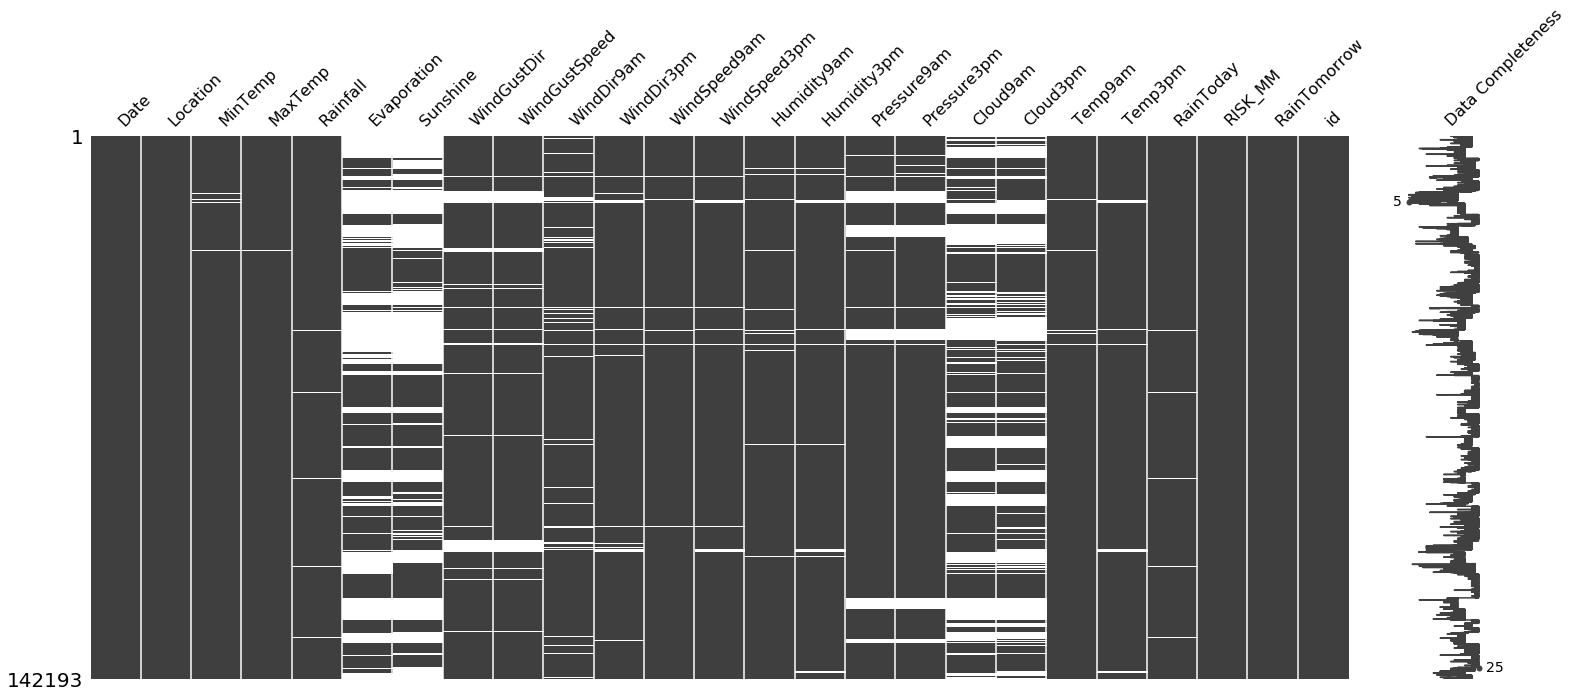

In [4]:
missingno.matrix(weather_df, labels=True)

# Location Overview

The location column are where they recorded the weather data during the day. It's noted that there is no missing data but it is categorical string data. Thus, one hot encoding is required and most likely certain location would not benefit the model with the increase dimensionality from the encoding. However, we will proceed with the feature engineerinig after imputing all the missing values


There are 49 locations.


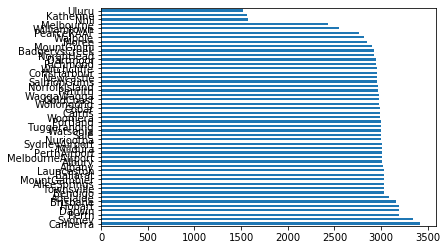

In [5]:
weather_df.Location.value_counts().plot(kind='barh')
print('There are {} locations.'.format(len(weather_df.Location.value_counts())))

# Temperature Overview
There are many temperature variables such as MinTemp, MaxTemp, Temp9am and Temp3pm. The main focus for the next couple cells will be imputing the missing values from Min and Max Temp. Min Temp and Max Temp from my intrepation means the minimum/lowest point and maximum/highest point of degrees during the day.

Generally with such a low count of missing values between the two, we will usually just use the mean or median. However, an issue will arise if a row has a Min temp = 25 and Max temp = 23. This does not make sense at all, therefore we will attempt to use K-Nearest Neighbors(KNN) to locate the most similiar point. As both Min and Max temperature have missing values, we will create a new dataframe with both variables but dropping all NaNs. This will be used to train the model and then for example if we are predicting Max we will create a new dataframe where Max = NaN with the Min Temp. Thus the model will use the Min Temp to determine and impute the missing values.

Another issue that arise from this method will be when both Min and Max temperature in a row is missing. Therefore, rather than deleting/removing the data, we will just fill it with the Mean on one side and continue with KNN approach. This will not be a perfect solution and most likely there will be a few rows where Min > Max which we will just make the Max = Min. 

Standard Practice of 10-fold Cross-Validation will be used on the model to ensure we will not be overfitting the model. We will also just use up to 50 Neighbors as if we are not happy with the results from the end predictive model then we will tweak this.

In [6]:
print(weather_df.MinTemp.describe())
print('There are {} missing values'.format(weather_df.MinTemp.isnull().sum()))

count    141556.000000
mean         12.186400
std           6.403283
min          -8.500000
25%           7.600000
50%          12.000000
75%          16.800000
max          33.900000
Name: MinTemp, dtype: float64
There are 637 missing values


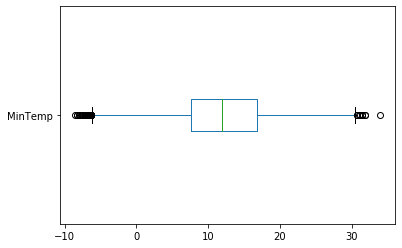

In [7]:
weather_df.MinTemp.plot(kind='box', vert=False)

In [8]:
print(weather_df.MaxTemp.describe())
print('There are {} missing values'.format(weather_df.MaxTemp.isnull().sum()))

count    141871.000000
mean         23.226784
std           7.117618
min          -4.800000
25%          17.900000
50%          22.600000
75%          28.200000
max          48.100000
Name: MaxTemp, dtype: float64
There are 322 missing values


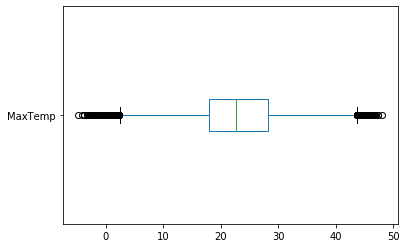

In [9]:
weather_df.MaxTemp.plot(kind='box', vert=False)

In [10]:
weather_df[weather_df.MaxTemp < weather_df.MinTemp]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,id


# Dealing with rows missing both min and max temp

Firstly we will make the missing matching MinTemp be 1000 as a placeholder and then locate the corresponding Max temp. We will just fill it with the medium and then change the MinTemp = 1000 as NaN.

In [11]:
weather_df.loc[weather_df.MaxTemp.isna() & weather_df.MinTemp.isna(), ['MinTemp']] = 1000
weather_df.loc[weather_df.MinTemp == 1000, ['MaxTemp']] = weather_df.MaxTemp.median()
weather_df.loc[weather_df['MinTemp'] == 1000, ['MinTemp']] = np.nan


In [12]:
weather_df.loc[weather_df.MinTemp.isnull() & weather_df.MaxTemp.isnull()] 

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,id


In [13]:
print('Missing Max Temp: {}, Missing Min Temp: {}'.format(weather_df.MaxTemp.isnull().sum(), weather_df.MinTemp.isnull().sum()))

Missing Max Temp: 234, Missing Min Temp: 637


In [14]:
def neighbor_search(x_train, x_test, y_train, y_test, i, score, timer):
    start_time = process_time()
    neighbor = KNeighborsRegressor(n_neighbors=i)
    neighbor.fit(X_train, y_train)
    predictions = neighbor.predict(X_test)
    mse = mean_squared_error(predictions, y_test)
    rmse = sqrt(mse)
    end_time = process_time()
    time_lapsed = end_time - start_time
    score.append(rmse)
    timer.append(time_lapsed)
    print('KNN on neighbors = {} has a rmse of {} and took {} seconds to compute'.format(i, rmse, time_lapsed))

In [15]:
def cv_neighbor_search(x_train, x_test, y_train, y_test, i, score, timer):
    start_time = process_time()
    neighbor = KNeighborsRegressor(n_neighbors=i)
    neighbor.fit(X_train, y_train)
    predictions = neighbor.predict(X_test)
    mse = mean_squared_error(predictions, y_test)
    rmse = sqrt(mse)
    end_time = process_time()
    time_lapsed = end_time - start_time
    score.append(rmse)
    timer.append(time_lapsed)

In [16]:
def neighbor_search_classifier(x_train, x_test, y_train, y_test, i, score, timer):
    start_time = process_time()
    neighbor = KNeighborsClassifier(n_neighbors=i)
    neighbor.fit(X_train, y_train)
    predictions = neighbor.predict(X_test)
    recall = recall_score(predictions, y_test, average = 'weighted')
    end_time = process_time()
    time_lapsed = end_time - start_time
    score.append(recall)
    timer.append(time_lapsed)
    print('KNN on neighbors = {} has a recall of {} and took {} seconds to compute'.format(i, recall, time_lapsed))

In [17]:
def cv_neighbor_search_classifier(x_train, x_test, y_train, y_test, i, score, timer):
    start_time = process_time()
    neighbor = KNeighborsClassifier(n_neighbors=i)
    neighbor.fit(X_train, y_train)
    predictions = neighbor.predict(X_test)
    recall = recall_score(predictions, y_test, average = 'weighted')
    end_time = process_time()
    time_lapsed = end_time - start_time
    score.append(recall)
    timer.append(time_lapsed)

In [18]:
neighbors_list = list(range(1,50))
neighbors = list(filter(lambda x: x %2 != 0, neighbors_list))

In [19]:
max_null = weather_df.loc[weather_df.MaxTemp.isnull(), ['MinTemp']]
min_null = weather_df.loc[weather_df.MinTemp.isnull(), ['MaxTemp']]

In [20]:
temp_df = pd.concat([weather_df.MaxTemp, weather_df.MinTemp], axis=1).dropna()
X, y = temp_df.loc[:, ['MinTemp']], temp_df['MaxTemp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [21]:
max_score = []
max_timer = []
for k in neighbors:
    neighbor_search(X_train, X_test, y_train, y_test, k, max_score, max_timer)

KNN on neighbors = 1 has a rmse of 6.781542024023599 and took 0.171875 seconds to compute
KNN on neighbors = 3 has a rmse of 5.689193466811331 and took 1.375 seconds to compute
KNN on neighbors = 5 has a rmse of 5.389036449222861 and took 1.625 seconds to compute
KNN on neighbors = 7 has a rmse of 5.197258706930612 and took 1.375 seconds to compute
KNN on neighbors = 9 has a rmse of 5.111150780373005 and took 1.5 seconds to compute
KNN on neighbors = 11 has a rmse of 5.050606118728501 and took 1.625 seconds to compute
KNN on neighbors = 13 has a rmse of 5.004965838249654 and took 1.625 seconds to compute
KNN on neighbors = 15 has a rmse of 4.975065551999592 and took 1.625 seconds to compute
KNN on neighbors = 17 has a rmse of 4.951732633023714 and took 1.5 seconds to compute
KNN on neighbors = 19 has a rmse of 4.936544310224405 and took 1.625 seconds to compute
KNN on neighbors = 21 has a rmse of 4.923701848647531 and took 1.75 seconds to compute
KNN on neighbors = 23 has a rmse of 4.9

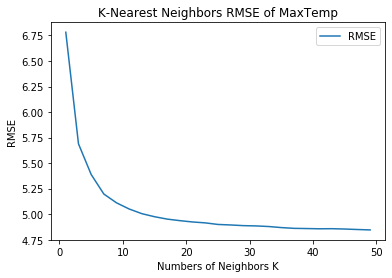

In [22]:
plt.plot(neighbors, max_score, label='RMSE')
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.legend(loc='upper right')
plt.title('K-Nearest Neighbors RMSE of MaxTemp')
plt.show()

In [23]:
cv_max_scores = []
cv_max_timer = []
kf = KFold(10, True)
fold = 0
for k in neighbors:
    temp_cv_scores = []
    for train, test in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train], X.values[test]
        y_train, y_test = y.values[train], y.values[test]
        cv_neighbor_search(X_train, X_test, y_train, y_test, k, temp_cv_scores, cv_max_timer)
    cv_max_scores.append(np.min(temp_cv_scores))
    cv_max_timer.append(np.min(cv_max_timer))

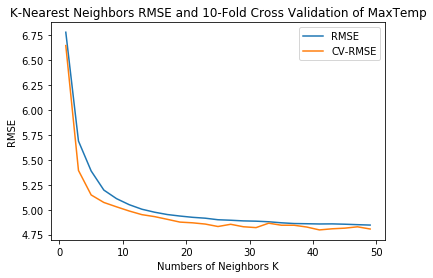

In [24]:
plt.plot(neighbors, max_score, label='RMSE') 
plt.plot(neighbors, cv_max_scores, label='CV-RMSE')
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.title('K-Nearest Neighbors RMSE and 10-Fold Cross Validation of MaxTemp')
plt.legend(loc='upper right')
plt.show()

In [25]:
optimal_k = neighbors[cv_max_scores.index(min(cv_max_scores))]
print(optimal_k)

41


In [26]:
max_model = KNeighborsRegressor(n_neighbors=41)
max_model.fit(X_train, y_train)
max_predictions = max_model.predict(max_null)
max_results = pd.DataFrame(max_predictions, columns=['MaxTemp'])
max_results = max_results.round(1)
weather_df['MaxTemp'] = weather_df['MaxTemp'].fillna(max_results['MaxTemp'].values[0])

In [27]:
weather_df.MaxTemp.describe()

count    142193.000000
mean         23.231947
std           7.110887
min          -4.800000
25%          17.900000
50%          22.600000
75%          28.200000
max          48.100000
Name: MaxTemp, dtype: float64

In [28]:
weather_df.loc[weather_df.MaxTemp < weather_df.MinTemp]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,id
139360,2013-11-03,Katherine,26.9,26.6,0.0,9.2,NaN,NE,33.0,N,...,1011.9,1006.7,5.0,4.0,31.0,41.0,No,0.0,No,139361
140444,2016-10-31,Katherine,28.0,26.6,0.0,14.6,NaN,NW,41.0,NNW,...,1010.7,1005.5,5.0,NaN,33.0,NaN,No,0.0,No,140445


In [29]:
weather_df.loc[weather_df.MaxTemp < weather_df.MinTemp, 'MaxTemp'] = weather_df['MinTemp']

In [30]:
weather_df.loc[weather_df.MaxTemp < weather_df.MinTemp, ['MinTemp', 'MaxTemp']]

,MinTemp,MaxTemp


# Minimum Temperature Imputation

In [31]:
temp_df = pd.concat([weather_df.MaxTemp, weather_df.MinTemp], axis=1).dropna()
X, y = temp_df.loc[:, ['MaxTemp']].dropna(), temp_df['MinTemp'].dropna()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [32]:
min_score = []
min_timer = []
for k in neighbors:
    neighbor_search(X_train, X_test, y_train, y_test, k, min_score, min_timer)

KNN on neighbors = 1 has a rmse of 6.0929635879413 and took 0.171875 seconds to compute
KNN on neighbors = 3 has a rmse of 4.9820011155224595 and took 1.25 seconds to compute
KNN on neighbors = 5 has a rmse of 4.66935231239157 and took 1.5 seconds to compute
KNN on neighbors = 7 has a rmse of 4.603313292810383 and took 1.5 seconds to compute
KNN on neighbors = 9 has a rmse of 4.53541846441478 and took 1.625 seconds to compute
KNN on neighbors = 11 has a rmse of 4.499249047220237 and took 1.640625 seconds to compute
KNN on neighbors = 13 has a rmse of 4.474584599641778 and took 1.5 seconds to compute
KNN on neighbors = 15 has a rmse of 4.449724350213095 and took 1.609375 seconds to compute
KNN on neighbors = 17 has a rmse of 4.4234093901689855 and took 1.625 seconds to compute
KNN on neighbors = 19 has a rmse of 4.414257280159893 and took 1.625 seconds to compute
KNN on neighbors = 21 has a rmse of 4.405242603787752 and took 1.515625 seconds to compute
KNN on neighbors = 23 has a rmse o

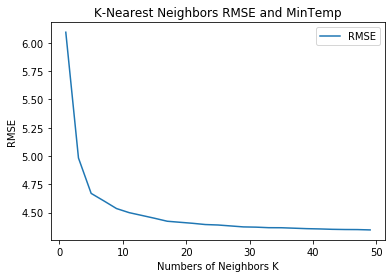

In [33]:
plt.plot(neighbors, min_score, label='RMSE')
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.title('K-Nearest Neighbors RMSE and MinTemp')
plt.legend(loc='upper right')
plt.show()

In [34]:
cv_min_scores = []
cv_min_timer = []
kf = KFold(10, True)
fold = 0
for k in neighbors:
    temp_cv_scores = []
    for train, test in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train], X.values[test]
        y_train, y_test = y.values[train], y.values[test]
        cv_neighbor_search(X_train, X_test, y_train, y_test, k, temp_cv_scores, cv_min_timer)
    cv_min_scores.append(np.min(temp_cv_scores))
    cv_min_timer.append(np.min(cv_max_timer))

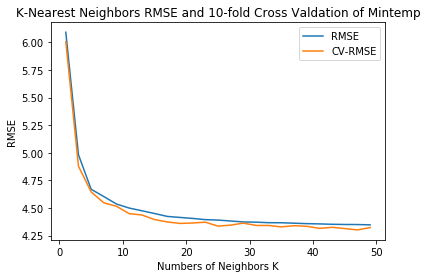

In [35]:
plt.plot(neighbors, min_score, label='RMSE')
plt.plot(neighbors, cv_min_scores, label='CV-RMSE')
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.title('K-Nearest Neighbors RMSE and 10-fold Cross Valdation of Mintemp')
plt.legend(loc ='upper right')
plt.show()

In [36]:
optimal_k = neighbors[cv_min_scores.index(min(cv_min_scores))]
print(optimal_k)

47


In [37]:
min_model = KNeighborsRegressor(n_neighbors=47)
min_model.fit(X_train, y_train)
min_predictions = min_model.predict(min_null)
min_results = pd.DataFrame(min_predictions, columns=['MinTemp'])
min_results = min_results.round(1)
weather_df['MinTemp'] = weather_df['MinTemp'].fillna(min_results['MinTemp'].values[0])

In [38]:
weather_df.MinTemp.describe()

count    142193.000000
mean         12.173021
std           6.392036
min          -8.500000
25%           7.600000
50%          12.000000
75%          16.800000
max          33.900000
Name: MinTemp, dtype: float64

In [39]:
weather_df[weather_df.MaxTemp < weather_df.MinTemp]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,id
50953,2009-06-06,MountGinini,9.2,3.2,NaN,NaN,NaN,WSW,43.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.4,Yes,50954
50973,2009-06-27,MountGinini,9.2,4.2,NaN,NaN,NaN,NNE,26.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.6,Yes,50974
50981,2009-07-07,MountGinini,9.2,-1.3,NaN,NaN,NaN,E,37.0,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.6,NaN,0.0,No,50982
51032,2009-08-30,MountGinini,9.2,0.1,32.6,NaN,NaN,W,102.0,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.4,Yes,2.4,Yes,51033
51034,2009-09-01,MountGinini,9.2,6.6,2.6,NaN,NaN,W,61.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0.0,No,51035
51038,2009-09-05,MountGinini,9.2,7.6,0.2,NaN,NaN,WSW,41.0,NaN,...,NaN,NaN,NaN,NaN,NaN,5.9,No,0.0,No,51039
51053,2009-09-24,MountGinini,9.2,4.9,NaN,NaN,NaN,SW,85.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,No,51054
51064,2009-10-05,MountGinini,9.2,8.6,6.4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Yes,3.8,Yes,51065
51065,2009-10-06,MountGinini,9.2,5.6,3.8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,Yes,5.4,Yes,51066
51070,2009-10-11,MountGinini,9.2,7.9,0.0,NaN,NaN,W,31.0,NaN,...,NaN,NaN,NaN,NaN,NaN,5.2,No,2.4,Yes,51071


MountGinini is most likely imputated with the same MinTemp

In [40]:
weather_df.loc[weather_df.MaxTemp < weather_df.MinTemp, ['MinTemp']] = weather_df['MaxTemp']

In [41]:
weather_df.loc[weather_df.MaxTemp < weather_df.MinTemp]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,id


In [42]:
print('There is {} missing values in MinTemp'.format(weather_df.MinTemp.isnull().sum()))
print('There is {} missing values in MaxTemp'.format(weather_df.MaxTemp.isnull().sum()))

There is 0 missing values in MinTemp
There is 0 missing values in MaxTemp


# Rainfall overview

As rainfall have 1406 missing values, we will just impute with the median due to the amount of outliers.

In [43]:
print(weather_df.Rainfall.describe())
print('There are {} missing values'.format(weather_df.Rainfall.isnull().sum()))

count    140787.000000
mean          2.349974
std           8.465173
min           0.000000
25%           0.000000
50%           0.000000
75%           0.800000
max         371.000000
Name: Rainfall, dtype: float64
There are 1406 missing values


In [44]:
weather_df.Rainfall.fillna(weather_df.Rainfall.median(), inplace = True)
weather_df.Rainfall.isnull().sum()

0

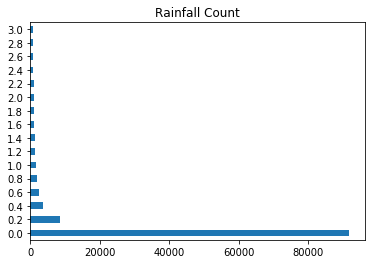

In [45]:
weather_df.Rainfall.value_counts()[:3].plot(kind='barh', title='Rainfall Count')

# Evaporation Overview

Evaporation is one of the main variable with many missing values. Once again, we will be using KNN to predict and impute this data. We will be using the 

In [46]:
print(weather_df.Evaporation.isnull().sum())
print(len(weather_df.Evaporation))

60843
142193


In [47]:
evaporation_null = weather_df.loc[weather_df.Evaporation.isnull(), ['MinTemp', 'MaxTemp']]

In [48]:
temp_df = pd.concat([weather_df.MinTemp, weather_df.MaxTemp, weather_df.Evaporation], axis=1).dropna()
X,y = temp_df.loc[:,['MinTemp', 'MaxTemp']], temp_df['Evaporation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [49]:
evaporation_score = []
evaporation_timer = []
for k in neighbors:
    neighbor_search(X_train, X_test, y_train, y_test, k, evaporation_score, evaporation_timer)

KNN on neighbors = 1 has a rmse of 4.645942708524419 and took 0.046875 seconds to compute
KNN on neighbors = 3 has a rmse of 3.8987614589440045 and took 0.5 seconds to compute
KNN on neighbors = 5 has a rmse of 3.7380522686779223 and took 0.375 seconds to compute
KNN on neighbors = 7 has a rmse of 3.657897607453515 and took 0.375 seconds to compute
KNN on neighbors = 9 has a rmse of 3.616596355103467 and took 0.625 seconds to compute
KNN on neighbors = 11 has a rmse of 3.591527063667694 and took 0.5 seconds to compute
KNN on neighbors = 13 has a rmse of 3.5659774292947923 and took 0.75 seconds to compute
KNN on neighbors = 15 has a rmse of 3.5518593699570054 and took 0.625 seconds to compute
KNN on neighbors = 17 has a rmse of 3.544751047952581 and took 0.625 seconds to compute
KNN on neighbors = 19 has a rmse of 3.5345683078039865 and took 0.625 seconds to compute
KNN on neighbors = 21 has a rmse of 3.5291555913631423 and took 0.625 seconds to compute
KNN on neighbors = 23 has a rmse 

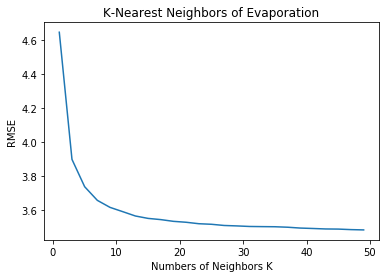

In [50]:
plt.plot(neighbors, evaporation_score)
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.title('K-Nearest Neighbors of Evaporation')
plt.show()

In [51]:
cv_evaporation_scores = []
cv_evaporation_timer = []
kf = KFold(10, True)
fold = 0
for k in neighbors:
    temp_cv_scores = []
    for train, test in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train], X.values[test]
        y_train, y_test = y.values[train], y.values[test]
        cv_neighbor_search(X_train, X_test, y_train, y_test, k, temp_cv_scores, cv_evaporation_timer)
    cv_evaporation_scores.append(np.min(temp_cv_scores))
    cv_evaporation_timer.append(np.min(cv_evaporation_timer))

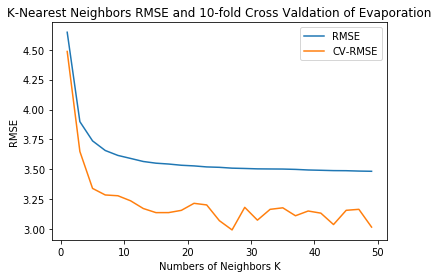

In [52]:
plt.plot(neighbors, evaporation_score, label='RMSE') 
plt.plot(neighbors, cv_evaporation_scores, label='CV-RMSE')
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.title('K-Nearest Neighbors RMSE and 10-fold Cross Valdation of Evaporation')
plt.legend(loc = 'upper right')
plt.show()

In [53]:
optimal_k = neighbors[cv_evaporation_scores.index(min(cv_evaporation_scores))]
print(optimal_k)

27


In [54]:
evaporation_model = KNeighborsRegressor(n_neighbors=27)
evaporation_model.fit(X_train, y_train)
evaporation_predictions = evaporation_model.predict(evaporation_null)
evaporation_results = pd.DataFrame(evaporation_predictions, columns=['Evaporation'])
evaporation_results = evaporation_results.round(1)
weather_df['Evaporation'] = weather_df['Evaporation'].fillna(evaporation_results['Evaporation'].values[0])

In [55]:
weather_df.Evaporation.describe()

count    142193.000000
mean          5.397158
std           3.169228
min           0.000000
25%           4.000000
50%           5.300000
75%           5.400000
max         145.000000
Name: Evaporation, dtype: float64

In [56]:
weather_df.Evaporation.isna().sum()

0

count    142193.000000
mean          5.397158
std           3.169228
min           0.000000
25%           4.000000
50%           5.300000
75%           5.400000
max         145.000000
Name: Evaporation, dtype: float64
0


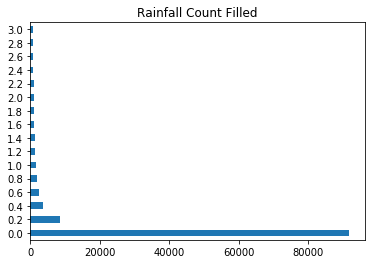

In [57]:
print(weather_df.Evaporation.describe())
print(weather_df.Evaporation.isnull().sum())
weather_df.Rainfall.value_counts()[:3].plot(kind='barh', title='Rainfall Count Filled')

# Sunshine overview

Sunshine is missing a lot of values too. Usually we will also apply the KNN search to predict the missing values however some domain knowledge needs to be applied here. We can not determine the amount of Sunshine through evaporation, min temp, and max temp. Perhaps with location but I believe a better values will be the clouds. As the more clouds there are, the less sunshine and vice versa. Therefore we will proceed to impute sunshine when we impute the clouds.

In [58]:
print(weather_df.Sunshine.describe())
print(weather_df.Sunshine.isnull().sum())

count    74377.000000
mean         7.624853
std          3.781525
min          0.000000
25%          4.900000
50%          8.500000
75%         10.600000
max         14.500000
Name: Sunshine, dtype: float64
67816


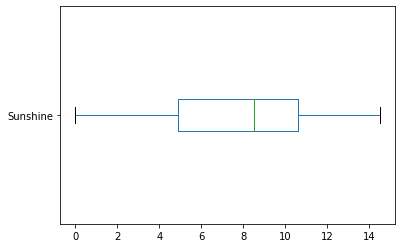

In [59]:
weather_df.Sunshine.plot(kind='box', vert=False)

# WindGustDirection Overview

There is no simple way to impute the missing values for this as it is categorical data. Currently, binning the missing values into a label under 'Unknown' will work fine as it allows us to retain the rows rather than deleting them.

However, a possible solution is to use a classifier prediction model to predict each possible direction of the wind and its likely hood. As there is only 16 possible wind direction, the classifier will need to be run 16 times. It is difficulty to guess the level of accuracy this will be.

Therefore, we will proceed in using the binning technique for now and possibly come back and revise on it.

W      9780
SE     9309
E      9071
N      9033
SSE    8993
S      8949
WSW    8901
SW     8797
SSW    8610
WNW    8066
NW     8003
ENE    7992
ESE    7305
NE     7060
NNW    6561
NNE    6433
Name: WindGustDir, dtype: int64
9330


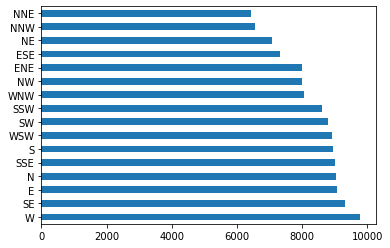

In [60]:
print(weather_df.WindGustDir.value_counts())
print(weather_df.WindGustDir.isnull().sum())
weather_df.WindGustDir.value_counts().plot(kind='barh')

In [61]:
weather_df.WindGustDir.fillna('UNKNOWN', inplace = True)
print(weather_df.WindGustDir.value_counts())
print('There is {} missing values for WindGustDir'.format(weather_df.WindGustDir.isna().sum()) )

W          9780
UNKNOWN    9330
SE         9309
E          9071
N          9033
SSE        8993
S          8949
WSW        8901
SW         8797
SSW        8610
WNW        8066
NW         8003
ENE        7992
ESE        7305
NE         7060
NNW        6561
NNE        6433
Name: WindGustDir, dtype: int64
There is 0 missing values for WindGustDir


# Wind Gust Speed

We will be imputing with median due to the amount of outliers in the variable. However we will try using the WindGustDir variable to help determine the speed. Probably won't affect much.

count    132923.000000
mean         39.984292
std          13.588801
min           6.000000
25%          31.000000
50%          39.000000
75%          48.000000
max         135.000000
Name: WindGustSpeed, dtype: float64
9270


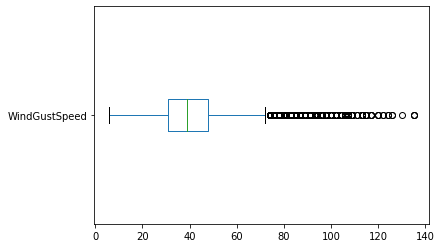

In [62]:
print(weather_df.WindGustSpeed.describe())
print(weather_df.WindGustSpeed.isnull().sum())
weather_df.WindGustSpeed.plot(kind='box', vert=False)

In [63]:
weather_df.WindGustSpeed.fillna(weather_df.groupby('WindGustDir')['WindGustSpeed'].transform("median"), inplace = True)
weather_df.WindGustSpeed.isna().sum()

0

In [64]:
print(weather_df.WindGustSpeed.describe())

count    142193.000000
mean         39.985316
std          13.138386
min           6.000000
25%          31.000000
50%          39.000000
75%          46.000000
max         135.000000
Name: WindGustSpeed, dtype: float64


# WindDir9am

Same as WindGustDir

N      11393
SE      9162
E       9024
SSE     8966
NW      8552
S       8493
W       8260
SW      8237
NNE     7948
NNW     7840
ENE     7735
ESE     7558
NE      7527
SSW     7448
WNW     7194
WSW     6843
Name: WindDir9am, dtype: int64
10013


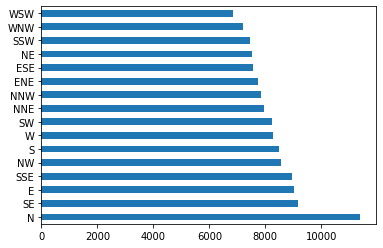

In [65]:
print(weather_df.WindDir9am.value_counts())
print(weather_df.WindDir9am.isnull().sum())
weather_df.WindDir9am.value_counts().plot(kind='barh')

In [66]:
weather_df.WindDir9am.fillna("UNKNOWN", inplace = True)
print("There is {} missing WindDir9am values".format(weather_df.WindDir9am.isna().sum()))

There is 0 missing WindDir9am values


# Wind Dir 3pm
Same as WindGustDir

SE     10663
W       9911
S       9598
WSW     9329
SW      9182
SSE     9142
N       8667
WNW     8656
NW      8468
ESE     8382
E       8342
NE      8164
SSW     8010
NNW     7733
ENE     7724
NNE     6444
Name: WindDir3pm, dtype: int64
3778


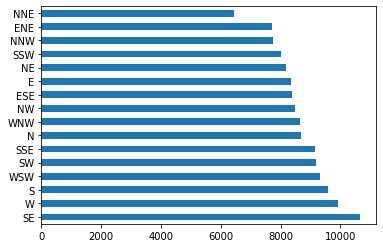

In [67]:
print(weather_df.WindDir3pm.value_counts())
print(weather_df.WindDir3pm.isnull().sum())
weather_df.WindDir3pm.value_counts().plot(kind='barh')

In [68]:
weather_df.WindDir3pm.fillna("UNKNOWN", inplace = True)
print("There is {} missing WindDir3pm values".format(weather_df.WindDir3pm.isna().sum()))

There is 0 missing WindDir3pm values


# WindSpeed9am

Same as WindGustSpeed

count    140845.000000
mean         14.001988
std           8.893337
min           0.000000
25%           7.000000
50%          13.000000
75%          19.000000
max         130.000000
Name: WindSpeed9am, dtype: float64
1348


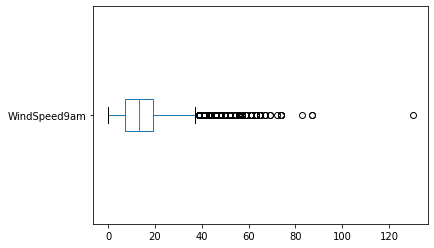

In [69]:
print(weather_df.WindSpeed9am.describe())
print(weather_df.WindSpeed9am.isnull().sum())
weather_df.WindSpeed9am.plot(kind='box', vert = False)

In [70]:
weather_df.WindSpeed9am.fillna(weather_df.WindSpeed9am.median(), inplace = True)
print('There is {} missing values for WindSpeed9am'.format(weather_df.WindSpeed9am.isna().sum()))

There is 0 missing values for WindSpeed9am


count    142193.000000
mean         13.992489
std           8.851614
min           0.000000
25%           7.000000
50%          13.000000
75%          19.000000
max         130.000000
Name: WindSpeed9am, dtype: float64


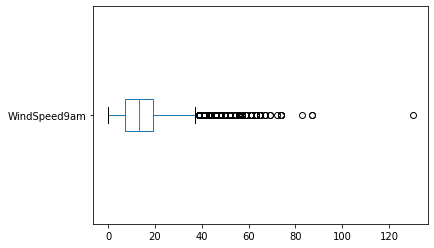

In [71]:
print(weather_df.WindSpeed9am.describe())
weather_df.WindSpeed9am.plot(kind='box', vert = False)

# Wind Speed 3pm
Same as WindGustSpeed

count    139563.000000
mean         18.637576
std           8.803345
min           0.000000
25%          13.000000
50%          19.000000
75%          24.000000
max          87.000000
Name: WindSpeed3pm, dtype: float64
2630


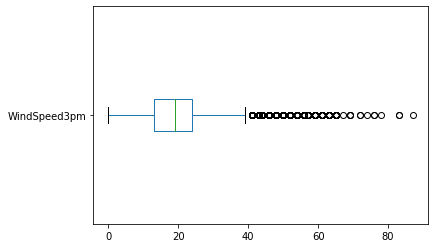

In [72]:
print(weather_df.WindSpeed3pm.describe())
print(weather_df.WindSpeed3pm.isnull().sum())
weather_df.WindSpeed3pm.plot(kind='box', vert = False)

In [73]:
weather_df.WindSpeed3pm.fillna(weather_df.WindSpeed3pm.median(), inplace = True)
print('There is {} missing values for WindSpeed3pm'.format(weather_df.WindSpeed3pm.isna().sum()))

There is 0 missing values for WindSpeed3pm


count    142193.000000
mean         18.644279
std           8.721688
min           0.000000
25%          13.000000
50%          19.000000
75%          24.000000
max          87.000000
Name: WindSpeed3pm, dtype: float64


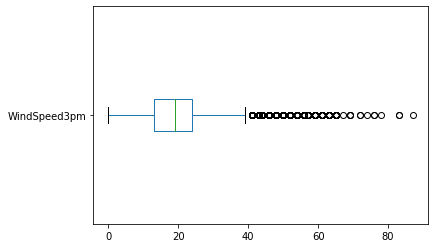

In [74]:
print(weather_df.WindSpeed3pm.describe())
weather_df.WindSpeed3pm.plot(kind='box', vert = False)

# Humidity 9am
Same as WindGustSpeed

count    140419.000000
mean         68.843810
std          19.051293
min           0.000000
25%          57.000000
50%          70.000000
75%          83.000000
max         100.000000
Name: Humidity9am, dtype: float64
1774


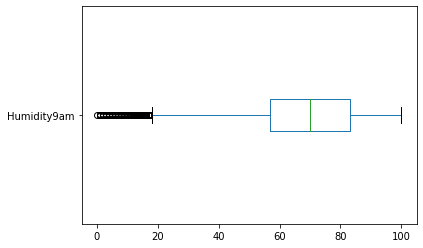

In [75]:
print(weather_df.Humidity9am.describe())
print(weather_df.Humidity9am.isnull().sum())
weather_df.Humidity9am.plot(kind='box', vert = False)

In [76]:
weather_df.Humidity9am.fillna(weather_df.Humidity9am.median(), inplace = True)
print('There is {} missing values for Humidity9am'.format(weather_df.Humidity9am.isna().sum()))

There is 0 missing values for Humidity9am


count    142193.000000
mean         68.858235
std          18.932512
min           0.000000
25%          57.000000
50%          70.000000
75%          83.000000
max         100.000000
Name: Humidity9am, dtype: float64


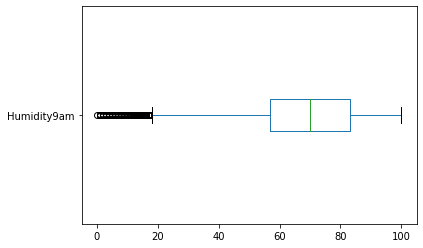

In [77]:
print(weather_df.Humidity9am.describe())
weather_df.Humidity9am.plot(kind='box', vert = False)

# Humidity3pm
Same as WindGustSpeed

count    138583.000000
mean         51.482606
std          20.797772
min           0.000000
25%          37.000000
50%          52.000000
75%          66.000000
max         100.000000
Name: Humidity3pm, dtype: float64
3610


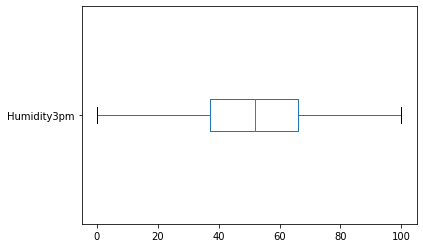

In [78]:
print(weather_df.Humidity3pm.describe())
print(weather_df.Humidity3pm.isnull().sum())
weather_df.Humidity3pm.plot(kind='box', vert = False)

In [79]:
weather_df.Humidity3pm.fillna(weather_df.Humidity3pm.median(), inplace = True)
print('There is {} missing values for Humidity3pm'.format(weather_df.Humidity3pm.isna().sum()))

There is 0 missing values for Humidity3pm


count    142193.000000
mean         51.495742
std          20.532227
min           0.000000
25%          37.000000
50%          52.000000
75%          65.000000
max         100.000000
Name: Humidity3pm, dtype: float64


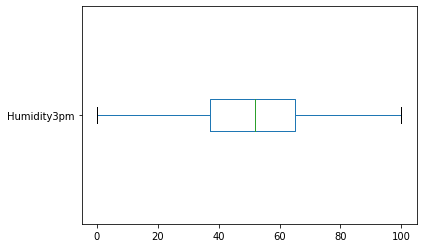

In [80]:
print(weather_df.Humidity3pm.describe())
weather_df.Humidity3pm.plot(kind='box', vert = False)

# Pressure9am
Same as WindGustSpeed

count    128179.000000
mean       1017.653758
std           7.105476
min         980.500000
25%        1012.900000
50%        1017.600000
75%        1022.400000
max        1041.000000
Name: Pressure9am, dtype: float64
14014


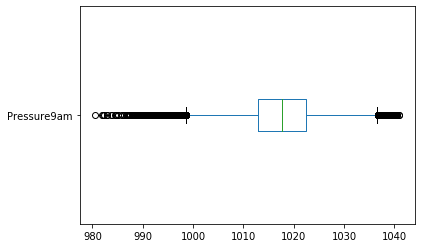

In [81]:
print(weather_df.Pressure9am.describe())
print(weather_df.Pressure9am.isnull().sum())
weather_df.Pressure9am.plot(kind='box', vert = False)

In [82]:
weather_df.Pressure9am.fillna(weather_df.groupby('WindSpeed9am')['Pressure9am'].transform("median"), inplace = True)
weather_df.Pressure9am.fillna(weather_df.Pressure9am.median(), inplace = True)
print('There is {} missing values for Pressure9am'.format(weather_df.Pressure9am.isna().sum()))

There is 0 missing values for Pressure9am


count    142193.000000
mean       1017.722537
std           6.772932
min         980.500000
25%        1013.500000
50%        1017.700000
75%        1021.800000
max        1041.000000
Name: Pressure9am, dtype: float64


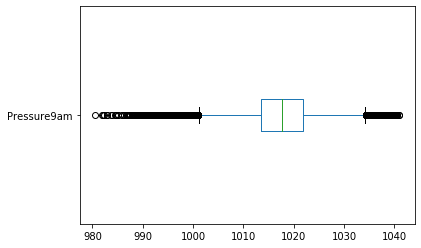

In [83]:
print(weather_df.Pressure9am.describe())
weather_df.Pressure9am.plot(kind='box', vert = False)

# Pressure3pm

count    128212.000000
mean       1015.258204
std           7.036677
min         977.100000
25%        1010.400000
50%        1015.200000
75%        1020.000000
max        1039.600000
Name: Pressure3pm, dtype: float64
13981


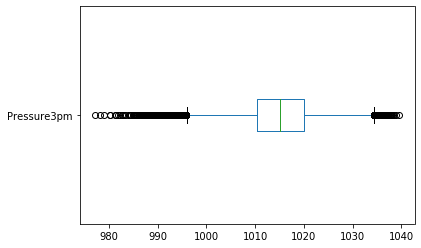

In [84]:
print(weather_df.Pressure3pm.describe())
print(weather_df.Pressure3pm.isnull().sum())
weather_df.Pressure3pm.plot(kind='box', vert = False)

In [85]:
weather_df.Pressure3pm.fillna(weather_df.groupby('WindSpeed3pm')['Pressure3pm'].transform("median"), inplace = True)
weather_df.Pressure3pm.fillna(weather_df.Pressure3pm.median(), inplace = True)
print('There is {} missing values for Pressure3pm'.format(weather_df.Pressure3pm.isna().sum()))

There is 0 missing values for Pressure3pm


# Temp9am

count    141289.000000
mean         16.987509
std           6.492838
min          -7.200000
25%          12.300000
50%          16.700000
75%          21.600000
max          40.200000
Name: Temp9am, dtype: float64
904


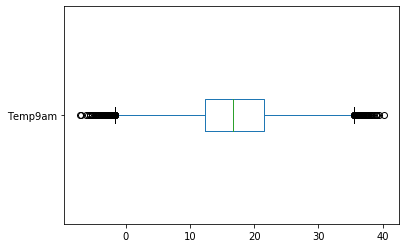

In [86]:
print(weather_df.Temp9am.describe())
print(weather_df.Temp9am.isnull().sum())
weather_df.Temp9am.plot(kind='box', vert = False)

In [87]:
weather_df.Temp9am.fillna(weather_df.groupby('MinTemp')['Temp9am'].transform("median"), inplace = True)
print('There is {} missing values for Temp9am'.format(weather_df.Temp9am.isna().sum()))

There is 0 missing values for Temp9am


count    142193.000000
mean         16.959450
std           6.494093
min          -7.200000
25%          12.300000
50%          16.700000
75%          21.500000
max          40.200000
Name: Temp9am, dtype: float64


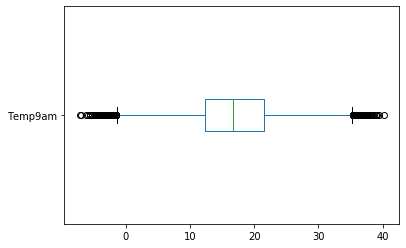

In [88]:
print(weather_df.Temp9am.describe())
weather_df.Temp9am.plot(kind='box', vert = False)

# Temp3pm
Same as WindGustDir

count    139467.000000
mean         21.687235
std           6.937594
min          -5.400000
25%          16.600000
50%          21.100000
75%          26.400000
max          46.700000
Name: Temp3pm, dtype: float64
2726


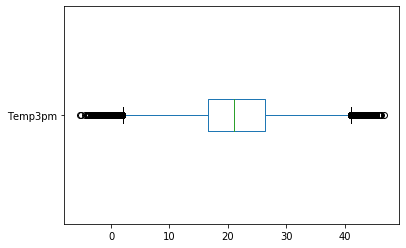

In [89]:
print(weather_df.Temp3pm.describe())
print(weather_df.Temp3pm.isnull().sum())
weather_df.Temp3pm.plot(kind='box', vert = False)

In [90]:
weather_df.Temp3pm.fillna(weather_df.groupby('MaxTemp')['Temp3pm'].transform("median"), inplace = True)
weather_df.Temp3pm.fillna(weather_df.Temp3pm.median(), inplace = True)
print('There is {} missing values for Temp3pm'.format(weather_df.Temp3pm.isna().sum()))

There is 0 missing values for Temp3pm


count    142193.000000
mean         21.724601
std           6.973558
min          -5.400000
25%          16.600000
50%          21.100000
75%          26.500000
max          46.700000
Name: Temp3pm, dtype: float64


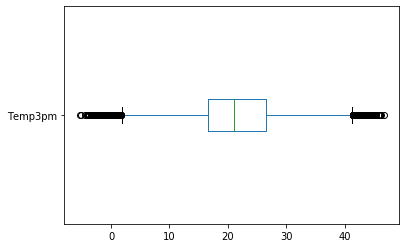

In [91]:
print(weather_df.Temp3pm.describe())
weather_df.Temp3pm.plot(kind='box', vert = False)

# RISK MM

### NOTE: USING THIS VALUE WILL GIVE PREDICTIONS OF WHETHER OR NOT IF IT WILL RAIN TOMORROW. DO NOT USE.


In [92]:
print(weather_df.RISK_MM.describe())
print(weather_df.RISK_MM.isnull().sum())

count    142193.000000
mean          2.360682
std           8.477969
min           0.000000
25%           0.000000
50%           0.000000
75%           0.800000
max         371.000000
Name: RISK_MM, dtype: float64
0


# RainToday

Important variable because if it rain today then it might possibly rain more the next day. And the data collection was through strings of 'Yes' and 'No'. So we will binarise it by a simple data dictionary map. Then we will use KNN to determine the missing values. Using rainfall, it should predict 100% accurate as if there is rainfall then there is rain. If there is no rainfall then no rain. 

## TO BE NOTED: Running the cross validation takes considerable amount of time

In [93]:
print(weather_df.RainToday.value_counts())
print(weather_df.RainToday.isnull().sum())

No     109332
Yes     31455
Name: RainToday, dtype: int64
1406


In [94]:
rain_dict = {'No': 0, 'Yes': 1}
weather_df['RainToday'] = weather_df['RainToday'].map(rain_dict)

In [95]:
(weather_df.loc[weather_df.RainToday.isnull(), ['Rainfall']] > 0).Rainfall.value_counts()
weather_df['RainToday'].fillna(0, inplace=True)

In [96]:
weather_df.RainToday.isnull().sum()

0

# Cloud 9am
Uncertain on what metric is being used to determine the clouds. So we will just proceed with using KNN to predict the missing values. In fact, it should be a multi-class binary issue. However we will just use regression for now and will fix this on later review.

count    88536.000000
mean         4.437189
std          2.887016
min          0.000000
25%          1.000000
50%          5.000000
75%          7.000000
max          9.000000
Name: Cloud9am, dtype: float64
53657


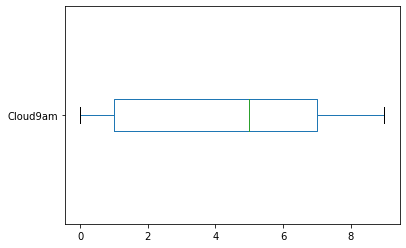

In [97]:
print(weather_df.Cloud9am.describe())
print(weather_df.Cloud9am.isnull().sum())
weather_df.Cloud9am.plot(kind='box', vert = False)

In [123]:
cloud9am_null = weather_df.loc[weather_df.Cloud9am.isnull(), ['Temp9am', 'WindSpeed9am', 'Humidity9am', 'Pressure9am']]

In [110]:
temp_df = pd.concat([weather_df.Temp9am, weather_df.WindSpeed9am, weather_df.Humidity9am, 
                              weather_df.Cloud9am, weather_df.Pressure9am], axis=1).dropna()
X,y = temp_df.iloc[:,temp_df.columns != 'Cloud9am'], temp_df['Cloud9am']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [111]:
cloud9am_score = []
cloud9am_timer = []
for k in neighbors:
    neighbor_search(X_train, X_test, y_train, y_test, k, cloud9am_score, cloud9am_timer)

KNN on neighbors = 1 has a rmse of 3.438962433026404 and took 0.125 seconds to compute
KNN on neighbors = 3 has a rmse of 2.8040727673389267 and took 0.171875 seconds to compute
KNN on neighbors = 5 has a rmse of 2.659584234250509 and took 0.1875 seconds to compute
KNN on neighbors = 7 has a rmse of 2.6017399060379582 and took 0.203125 seconds to compute
KNN on neighbors = 9 has a rmse of 2.563968125066214 and took 0.234375 seconds to compute
KNN on neighbors = 11 has a rmse of 2.5372476086771183 and took 0.234375 seconds to compute
KNN on neighbors = 13 has a rmse of 2.523462969456337 and took 0.25 seconds to compute
KNN on neighbors = 15 has a rmse of 2.5114073005028272 and took 0.390625 seconds to compute
KNN on neighbors = 17 has a rmse of 2.50273778633754 and took 1.59375 seconds to compute
KNN on neighbors = 19 has a rmse of 2.494479675285486 and took 1.71875 seconds to compute
KNN on neighbors = 21 has a rmse of 2.4896079778760303 and took 1.734375 seconds to compute
KNN on neig

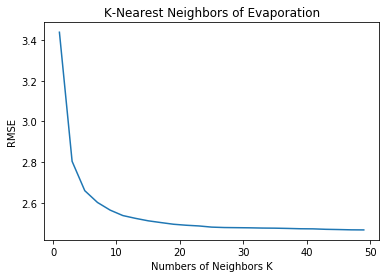

In [112]:
plt.plot(neighbors, cloud9am_score)
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.title('K-Nearest Neighbors of Evaporation')
plt.show()

In [113]:
cv_cloud9am_scores = []
cv_cloud9am_timer = []
kf = KFold(10, True)
fold = 0
for k in neighbors:
    temp_cv_scores = []
    for train, test in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train], X.values[test]
        y_train, y_test = y.values[train], y.values[test]
        cv_neighbor_search(X_train, X_test, y_train, y_test, k, temp_cv_scores, cv_cloud9am_timer)
    cv_cloud9am_scores.append(np.min(temp_cv_scores))
    cv_cloud9am_timer.append(np.min(cv_max_timer))

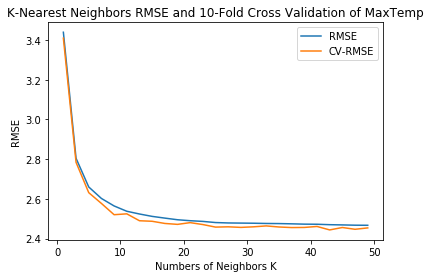

In [115]:
plt.plot(neighbors, cloud9am_score, label='RMSE') 
plt.plot(neighbors, cv_cloud9am_scores, label='CV-RMSE')
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.title('K-Nearest Neighbors RMSE and 10-Fold Cross Validation of MaxTemp')
plt.legend(loc='upper right')
plt.show()

In [117]:
optimal_k = neighbors[cv_cloud9am_scores.index(min(cv_cloud9am_scores))]
print(optimal_k)

43


In [126]:
cloud9am_model = KNeighborsRegressor(n_neighbors=43)
cloud9am_model.fit(X_train, y_train)
cloud9am_predictions = cloud9am_model.predict(cloud9am_null)
cloud9am_results = pd.DataFrame(cloud9am_predictions, columns=['cloud9am'])
cloud9am_results = cloud9am_results.round(1)
weather_df['Cloud9am'] = weather_df['Cloud9am'].fillna(cloud9am_results['cloud9am'].values[0])

count    142193.000000
mean          3.743920
std           2.445956
min           0.000000
25%           2.600000
50%           2.600000
75%           6.000000
max           9.000000
Name: Cloud9am, dtype: float64
0


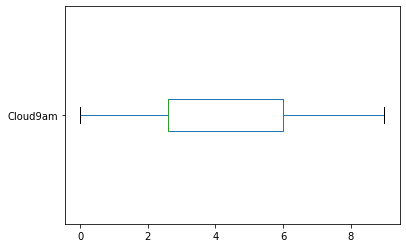

In [127]:
print(weather_df.Cloud9am.describe())
print(weather_df.Cloud9am.isnull().sum())
weather_df.Cloud9am.plot(kind='box', vert = False)

# Cloud3pm
Same as cloud9am

count    85099.000000
mean         4.503167
std          2.720633
min          0.000000
25%          2.000000
50%          5.000000
75%          7.000000
max          9.000000
Name: Cloud3pm, dtype: float64
57094


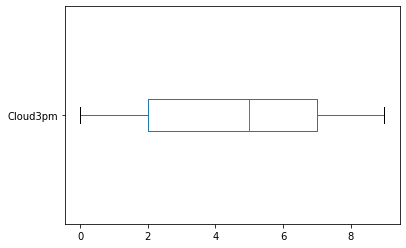

In [128]:
print(weather_df.Cloud3pm.describe())
print(weather_df.Cloud3pm.isnull().sum())
weather_df.Cloud3pm.plot(kind='box', vert = False)

In [129]:
cloud3pm_null = weather_df.loc[weather_df.Cloud3pm.isnull(), ['Temp9am', 'WindSpeed9am', 'Humidity9am', 'Pressure9am', 
                                                              'Cloud9am']]

In [130]:
temp_df = pd.concat([weather_df.Temp9am, weather_df.WindSpeed9am, weather_df.Humidity9am, 
                              weather_df.Cloud9am, weather_df.Pressure9am, weather_df.Cloud3pm], axis=1).dropna()
X,y = temp_df.iloc[:,temp_df.columns != 'Cloud3pm'], temp_df['Cloud3pm']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [131]:
cloud3pm_score = []
cloud3pm_timer = []
for k in neighbors:
    neighbor_search(X_train, X_test, y_train, y_test, k, cloud3pm_score, cloud3pm_timer)

KNN on neighbors = 1 has a rmse of 3.01142555964656 and took 0.125 seconds to compute
KNN on neighbors = 3 has a rmse of 2.4446477025015008 and took 0.1875 seconds to compute
KNN on neighbors = 5 has a rmse of 2.32904361988215 and took 0.21875 seconds to compute
KNN on neighbors = 7 has a rmse of 2.2776117509655607 and took 0.234375 seconds to compute
KNN on neighbors = 9 has a rmse of 2.2432291466858154 and took 0.265625 seconds to compute
KNN on neighbors = 11 has a rmse of 2.2257458974447717 and took 0.28125 seconds to compute
KNN on neighbors = 13 has a rmse of 2.2118761262211697 and took 0.296875 seconds to compute
KNN on neighbors = 15 has a rmse of 2.2017447887749175 and took 0.3125 seconds to compute
KNN on neighbors = 17 has a rmse of 2.1968836984373024 and took 0.328125 seconds to compute
KNN on neighbors = 19 has a rmse of 2.1923122153870325 and took 1.78125 seconds to compute
KNN on neighbors = 21 has a rmse of 2.190030165059805 and took 1.796875 seconds to compute
KNN on n

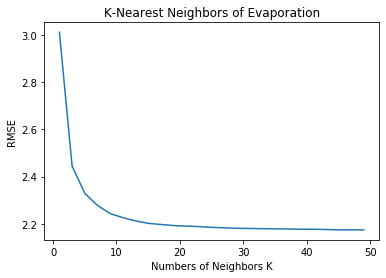

In [132]:
plt.plot(neighbors, cloud3pm_score)
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.title('K-Nearest Neighbors of Evaporation')
plt.show()

In [133]:
cv_cloud3pm_scores = []
cv_cloud3pm_timer = []
kf = KFold(10, True)
fold = 0
for k in neighbors:
    temp_cv_scores = []
    for train, test in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train], X.values[test]
        y_train, y_test = y.values[train], y.values[test]
        cv_neighbor_search(X_train, X_test, y_train, y_test, k, temp_cv_scores, cv_cloud3pm_timer)
    cv_cloud3pm_scores.append(np.min(temp_cv_scores))
    cv_cloud3pm_timer.append(np.min(cv_max_timer))

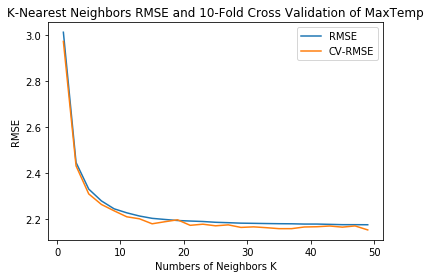

In [134]:
plt.plot(neighbors, cloud3pm_score, label='RMSE') 
plt.plot(neighbors, cv_cloud3pm_scores, label='CV-RMSE')
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.title('K-Nearest Neighbors RMSE and 10-Fold Cross Validation of MaxTemp')
plt.legend(loc='upper right')
plt.show()

In [136]:
optimal_k = neighbors[cv_cloud3pm_scores.index(min(cv_cloud3pm_scores))]
print(optimal_k)

49


In [137]:
cloud3pm_model = KNeighborsRegressor(n_neighbors=49)
cloud3pm_model.fit(X_train, y_train)
cloud3pm_predictions = cloud3pm_model.predict(cloud3pm_null)
cloud3pm_results = pd.DataFrame(cloud3pm_predictions, columns=['cloud3pm'])
cloud3pm_results = cloud3pm_results.round(1)
weather_df['Cloud3pm'] = weather_df['Cloud3pm'].fillna(cloud3pm_results['cloud3pm'].values[0])

count    142193.000000
mean          5.144335
std           2.245561
min           0.000000
25%           4.000000
50%           6.100000
75%           6.100000
max           9.000000
Name: Cloud3pm, dtype: float64
0


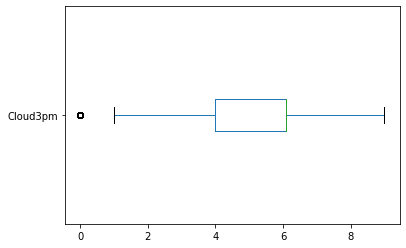

In [138]:
print(weather_df.Cloud3pm.describe())
print(weather_df.Cloud3pm.isnull().sum())
weather_df.Cloud3pm.plot(kind='box', vert = False)

# Sunshine

Sunshine is the last variable with missing values. We will be using multiple variables to help predict it such as cloud3pm, 9am and whether if it rained or not.

count    74377.000000
mean         7.624853
std          3.781525
min          0.000000
25%          4.900000
50%          8.500000
75%         10.600000
max         14.500000
Name: Sunshine, dtype: float64
67816


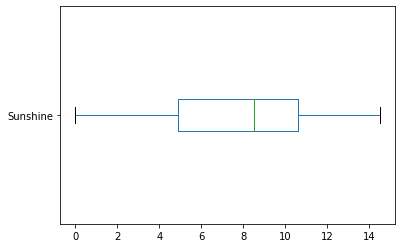

In [139]:
print(weather_df.Sunshine.describe())
print(weather_df.Sunshine.isnull().sum())
weather_df.Sunshine.plot(kind='box', vert = False)

In [129]:
sunshine_null = weather_df.loc[weather_df.Sunshine.isnull(), ['RainToday', 'Rainfall', 'Cloud9am', 'Cloud3pm']]

In [140]:
temp_df = pd.concat([weather_df.Cloud3pm, weather_df.Cloud9am, weather_df.RainToday, 
                     weather_df.Rainfall, weather_df.Sunshine], axis=1).dropna()
X,y = temp_df.iloc[:,temp_df.columns != 'Sunshine'], temp_df['Sunshine']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [141]:
sunshine_score = []
sunshine_timer = []
for k in neighbors:
    neighbor_search(X_train, X_test, y_train, y_test, k, sunshine_score, sunshine_timer)

KNN on neighbors = 1 has a rmse of 3.2416974638134155 and took 0.875 seconds to compute
KNN on neighbors = 3 has a rmse of 2.7839779091643857 and took 0.890625 seconds to compute
KNN on neighbors = 5 has a rmse of 2.6712790386012557 and took 0.890625 seconds to compute
KNN on neighbors = 7 has a rmse of 2.5833443909988834 and took 0.90625 seconds to compute
KNN on neighbors = 9 has a rmse of 2.5387357552058147 and took 0.890625 seconds to compute
KNN on neighbors = 11 has a rmse of 2.497340572916156 and took 0.90625 seconds to compute
KNN on neighbors = 13 has a rmse of 2.467575019049286 and took 0.90625 seconds to compute
KNN on neighbors = 15 has a rmse of 2.4392665616509004 and took 0.921875 seconds to compute
KNN on neighbors = 17 has a rmse of 2.4294230261743666 and took 0.90625 seconds to compute
KNN on neighbors = 19 has a rmse of 2.43032027976557 and took 0.921875 seconds to compute
KNN on neighbors = 21 has a rmse of 2.43367655040398 and took 2.34375 seconds to compute
KNN on 

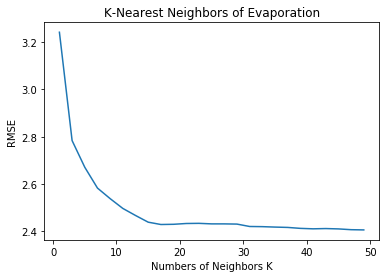

In [142]:
plt.plot(neighbors, sunshine_score)
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.title('K-Nearest Neighbors of Evaporation')
plt.show()

In [143]:
cv_sunshine_scores = []
cv_sunshine_timer = []
kf = KFold(10, True)
fold = 0
for k in neighbors:
    temp_cv_scores = []
    for train, test in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train], X.values[test]
        y_train, y_test = y.values[train], y.values[test]
        cv_neighbor_search(X_train, X_test, y_train, y_test, k, temp_cv_scores, cv_sunshine_timer)
    cv_sunshine_scores.append(np.min(temp_cv_scores))
    cv_sunshine_timer.append(np.min(cv_max_timer))

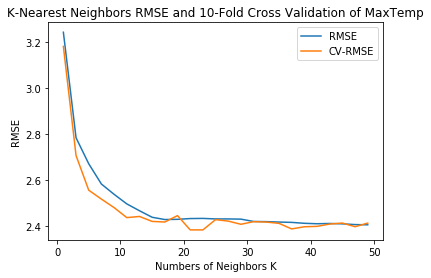

In [145]:
plt.plot(neighbors, sunshine_score, label='RMSE') 
plt.plot(neighbors, cv_sunshine_scores, label='CV-RMSE')
plt.xlabel('Numbers of Neighbors K')
plt.ylabel('RMSE')
plt.title('K-Nearest Neighbors RMSE and 10-Fold Cross Validation of MaxTemp')
plt.legend(loc='upper right')
plt.show()

In [147]:
optimal_k = neighbors[cv_sunshine_scores.index(min(cv_sunshine_scores))]
print(optimal_k)

23


In [148]:
sunshine_model = KNeighborsRegressor(n_neighbors=23)
sunshine_model.fit(X_train, y_train)
sunshine_predictions = sunshine_model.predict(sunshine_null)
sunshine_results = pd.DataFrame(sunshine_predictions, columns=['sunshine'])
sunshine_results = sunshine_results.round(1)
weather_df['Sunshine'] = weather_df['Sunshine'].fillna(sunshine_results['sunshine'].values[0])

NameError: name 'sunshine_null' is not defined

In [ ]:
print(weather_df.Sunshine.describe())
print(weather_df.Sunshine.isnull().sum())
weather_df.Sunshine.plot(kind='box', vert = False)

# Final Missing Data Visualisation

All data is filled

In [ ]:
missingno.matrix(weather_df, labels=True)

In [ ]:
weather_df.to_csv('WeatherAusReady.csv')